<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/1_updated_Creating_an_unbiased_universe_for_cross_sectional_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1:  Creating an unbiased universe for cross-sectional analysis - updated with Coindcodex data

In this notebook, we create an unbiased universe for cross-sectional analysis of cryptocurrency returns.

First, we load dependencies and price data from the coincodex dataset.

Then we remove instruments we don't want (stablecoin, wrapped tokens, duplicate coins etc).

Then, as our universe, we pick the top n by market cap on the previous day.

We don't throw away price observations but, rather, we simply flag each ticker/date observation with whether the asset was in the universe on that date.

Analysis of the returns suggests that the coincodex coin selection may upward bias the dataset somewhat, despite our care with building this universe. We must be aware of this potential in all our analysis using this dataset.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp53vRmA/remotesb038105ea5/RWLab-rwRtools-f742350/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.53.tar.gz’



In [47]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

# snippet: rw crypto load coincodex data v0.1
prices <- rwRtools::crypto_get_coincodex()
prices %>%
  head()

Authorization successful!

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,Price,Volume,MarketCapUSD
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTCD,2017-01-01,3.500750e+00,2.141424e+03,4.513253e+06
TGC,2017-01-01,3.355230e-04,1.809028e+01,1.461090e+04
ATOM,2017-01-02,1.210969e-02,5.763597e+03,9.059482e+04
BTC,2017-01-02,1.016241e+03,1.871437e+08,1.634320e+10
BTCD,2017-01-02,3.389330e+00,2.864861e+03,4.516087e+06
DASH,2017-01-02,1.156342e+01,3.853539e+06,8.113380e+07


# Remove unwanted assets from our dataset
## Remove Stablecoins

We want to do cross-sectional returns analysis on things that move. We don't want stablecoins in our dataset.

In [48]:
# snippet: rw crypto remove stablecoins v0.3

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

print(stables)

# Remove stablecoins from data set
prices <- prices %>%
  filter(!Ticker %in% stables)

  [1] "USDT"     "USDC"     "USTC"     "BUSD"     "DAI"      "FRAX"    
  [7] "TUSD"     "LUSD"     "FEI"      "MIM"      "USDP"     "USDN"    
 [13] "YUSD"     "USDD"     "DOLA"     "PAI"      "HUSD"     "NUSD"    
 [19] "GUSD"     "ALUSD"    "FLEXUSD"  "SUSD"     "OUSD"     "CUSD"    
 [25] "RSV"      "MUSD"     "USDK"     "VAI"      "TOR"      "DOC"     
 [31] "USDS"     "USDS"     "USDP"     "USDB"     "MAI"      "USDR"    
 [37] "USDJ"     "STBL"     "VOLT"     "RAI"      "FLOAT"    "USDX"    
 [43] "ZUSD"     "USX"      "aSEED"    "USD+"     "BAI"      "EURT"    
 [49] "EUROC"    "EURS"     "CEUR"     "SEUR"     "USN"      "AGEUR"   
 [55] "PAR"      "USH"      "3USD"     "SIGUSD"   "HOME"     "FIAT"    
 [61] "PUSD"     "FUSD"     "UXD"      "USDH"     "FPI"      "BEAN"    
 [67] "USDL"     "PUSD"     "DUSD"     "VST"      "KUSD"     "USDTZ"   
 [73] "MONEY"    "UUSD"     "USDI"     "EURL"     "NOTE"     "HAY"     
 [79] "USK"      "ARUSD"    "USDW"     "BOB"      "USDR"     "UZ

In [49]:
prices %>% distinct(Ticker) %>% pull() %>% sort()

[1] "10SET"    "1INCH"    "AAVE"     "ABBC"     "ACA"      "ACH4"    
  [7] "ACS2"     "ADA"      "AETH2"    "AGIX"     "AGLA"     "AGLD"    
 [13] "AKRO"     "AKT"      "ALGO"     "ALPHA"    "ALPHA8"   "AMP"     
 [19] "ANKR"     "ANT"      "ANY"      "APE"      "API3"     "APT"     
 [25] "AR"       "ARB"      "ARDR"     "ARK"      "ARKM"     "ARPA"    
 [31] "ARRR"     "ASD"      "ASTR"     "ASTRAFER" "ATA"      "ATOM"    
 [37] "AUCTION"  "AUDIO"    "AURA"     "AVAX"     "AVINOC"   "AXEL"    
 [43] "AXL"      "AXS"      "AZERO"    "BABYDOGE" "BAD"      "BADGER"  
 [49] "BAKE"     "BAL"      "BAND"     "BAT"      "BCH"      "BCHSV"   
 [55] "BDX"      "BEE"      "BEL"      "BETA"     "BFC3"     "BGB"     
 [61] "BHAO"     "BICO"     "BIT"      "BLD"      "BLUR"     "BLZ"     
 [67] "BNB"      "BNT"      "BONE2"    "BORA"     "BRISE"    "BSC2"    
 [73] "BSW"      "BTC"      "BTCD"     "BTG"      "BTM"      "BTRST"   
 [79] "BTT"      "C98"      "CAKE"     "CBK"      "CCD"      "CDT"     
 [85] "CEEK"     "CEL"      "CELO"     "CELR"     "CFG"      "CFX2"    
 [91] "CHNG"     "CHR"      "CHSB"     "CHZ"      "CKB"      "CNX"     
 [97] "COCOS"    "COL1"     "COMBO1"   "COMP"     "COTI"     "CRE2"    
[103] "CRO"      "CRV"      "CSPR"     "CTK"      "CTSI"     "CVC"     
[109] "CVX"      "CWEB"     "CXO"      "CYBER"    "DAG"      "DAO"     
[115] "DAR2"     "DASH"     "DCR"      "DENT"     "DERO"     "DESO"    
[121] "DEXE"     "DEXT"     "DFI"      "DGB"      "DICE1"    "DKA"     
[127] "DOGE"     "DOT"      "DPI"      "DUSK"     "DXD"      "DYDX"    
[133] "ECHO"     "EDU"      "EFI"      "EGLD"     "ELA"      "ELF"     
[139] "ELG"      "ELON"     "ENJ"      "ENS"      "EOS"      "EPS2"    
[145] "ERG"      "ETC"      "ETH"      "ETHW"     "ETN"      "EVER"    
[151] "EWT"      "EXRD"     "FCT2"     "FET"      "FEVO"     "FIL"     
[157] "FIL2"     "FLETA"    "FLEX"     "FLM"      "FLOKI"    "FLOW"    
[163] "FLR"      "FLUX"     "FNSA"     "FORT"     "FORTH"    "FTM"     
[169] "FTT2"     "FUN"      "FX"       "FXS"      "GAL"      "GALA"    
[175] "GFCC"     "GHST"     "GLAI"     "GLM"      "GLMR"     "GMT"     
[181] "GMT3"     "GMT6"     "GMX"      "GNO"      "GNS"      "GODS"    
[187] "GRN"      "GRS"      "GRT"      "GT2"      "GTC6"     "HBAR"    
[193] "HBC2"     "HBTC"     "HFT1"     "HIGH2"    "HIVE"     "HNT"     
[199] "HOOK"     "HOT2"     "HT"       "HXRO"     "IBBTC"    "ICP"     
[205] "ICX"      "ID2"      "IDEX"     "ILV"      "IMX3"     "INJ"     
[211] "IOST"     "IOT"      "IOTX"     "IQ"       "IRIS"     "JASMY"   
[217] "JOE"      "JST"      "KAS"      "KAVA"     "KCS"      "KDA"     
[223] "KEEP"     "KIN"      "KLAY"     "KMD"      "KNC"      "KRD"     
[229] "KSM"      "KSP"      "KUB1"     "KUJI"     "KWENTA"   "LADYS"   
[235] "LAT2"     "LCX2"     "LDO"      "LEASH"    "LEND"     "LEO"     
[241] "LEVER"    "LINA2"    "LINK"     "LOCUS"    "LOOKS"    "LOOM"    
[247] "LPT"      "LQTY"     "LRC"      "LSK"      "LTC"      "LUNA"    
[253] "LUNC"     "LYRA1"    "LYXE"     "MAGIC"    "MAID"     "MANA"    
[259] "MASK"     "MATIC"    "MAV"      "MBL2"     "MBOX2"    "MC3"     
[265] "MCASH"    "MCB3"     "MDT"      "MDX3"     "MED"      "META2"   
[271] "MFT"      "MGC"      "MINA"     "MKR"      "MNW"      "MOB"     
[277] "MOON"     "MOON5"    "MOVR"     "MSOL"     "MTL"      "MUSD2"   
[283] "NAKA"     "NANO"     "NEAR"     "NEAR2"    "NEO"      "NEXO"    
[289] "NFT3"     "NKN"      "NMR"      "NU"       "NUSD1"    "NVIR"    
[295] "NXM"      "NXRA"     "NYM"      "OAS"      "OCN2"     "OGN"     
[301] "OHM2"     "OKB"      "OMG"      "OMI"      "ONE"      "ONG"     
[307] "ONT"      "ONUS"     "OP"       "ORBS"     "ORC"      "ORDI"    
[313] "OSMO"     "OXT"      "PAXG"     "PENDLE"   "PEOPLE"   "PEPE"    
[319] "PERP"     "PHA"      "PLA4"     "PLTC"     "PNDC"     "POKT"    
[325] "POLY"     "POND"     "POWR"     "PRIME"    "PROM"     "PUNDIX"  
[331] "PYR"      "QC"       "QKC"      "QN

## Remove duplicate assets

Our universe contains duplicate assets on different protocols, as well as wrapped versions of coins. We want to remove these from our analysis.

In [50]:
prices %>%
  distinct(Ticker) %>%
  mutate(first3 = str_sub(Ticker, 1,3)) %>%
  group_by(first3) %>%
  summarise(tickercount = n()) %>%
  filter(tickercount > 1) %>%
  arrange(desc(tickercount))

first3,tickercount
<chr>,<int>
CEL,3
GMT,3
AGL,2
ALP,2
ARK,2
AST,2
BAD,2
BCH,2
BTC,2


Not all of those represent the same assets, but some do.

Let's see how this stuff overlaps...

`summarise()` has grouped output by 'first3'. You can override using the
`.groups` argument.


first3,Ticker,observations,start_date,end_date
<chr>,<chr>,<int>,<date>,<date>
BCH,BCH,2234,2017-07-24,2023-09-05
BCH,BCHSV,1761,2018-11-09,2023-09-05
BTC,BTCD,642,2017-01-01,2018-10-04
BTC,BTC,2437,2017-01-02,2023-09-05
ETH,ETH,2437,2017-01-02,2023-09-05
ETH,ETHW,394,2022-08-08,2023-09-05
GLM,GLM,2219,2017-08-07,2023-09-05
GLM,GLMR,602,2022-01-12,2023-09-05
LUN,LUNC,1582,2019-05-07,2023-09-05


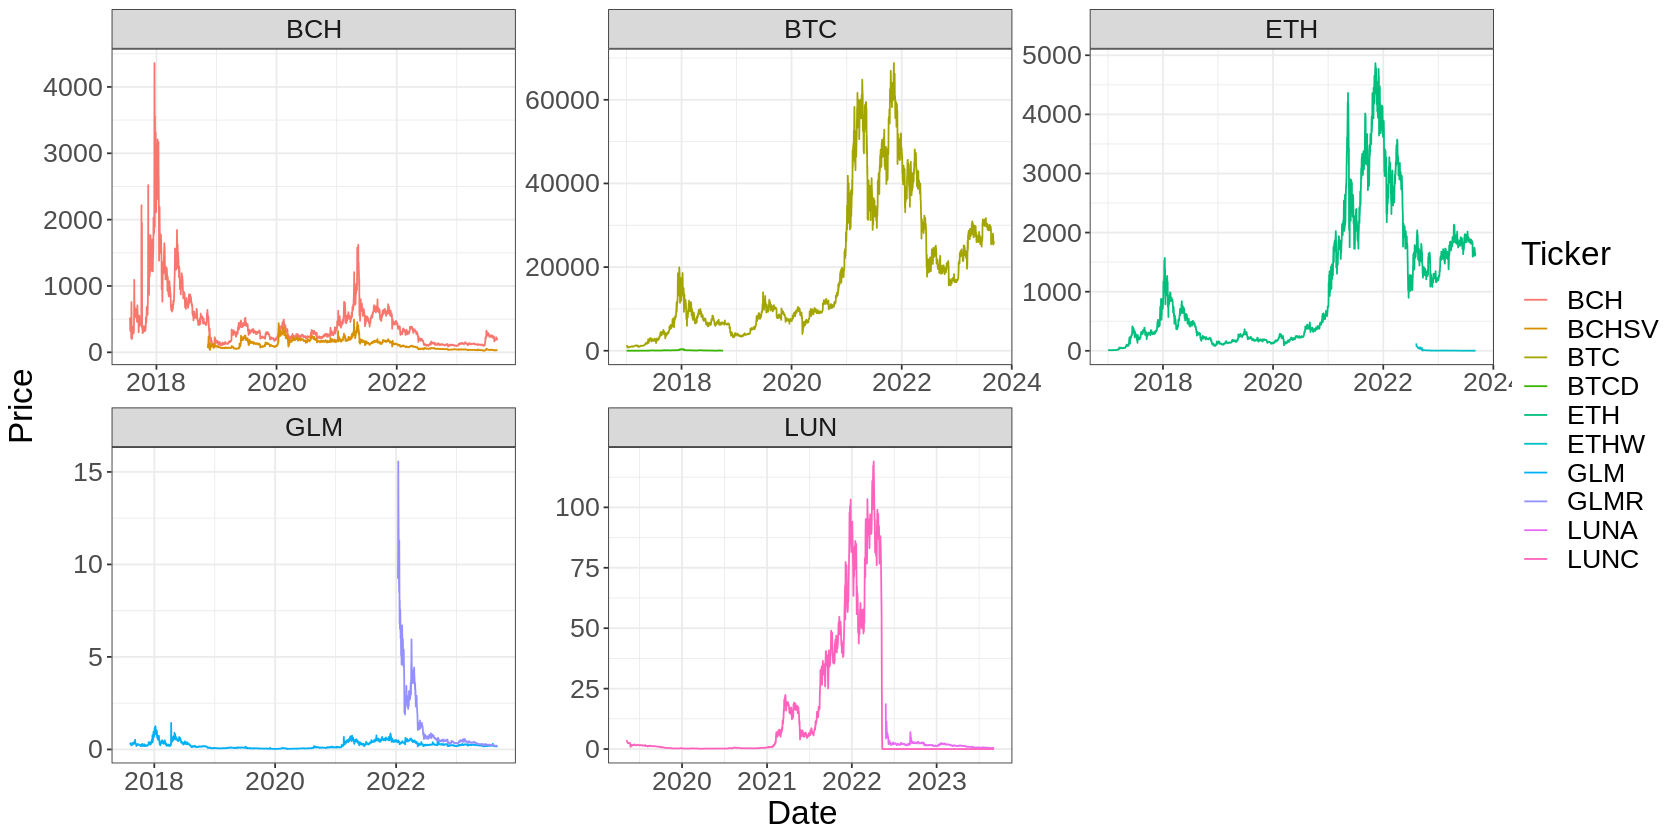

In [51]:
prices %>%
  mutate(first3 = str_sub(Ticker, 1,3)) %>%
  filter(first3 %in% c('BTC','ETH','GLM','LUN','BCH')) %>%
  group_by(first3, Ticker) %>%
  summarise(observations = n(),
            start_date = min(Date),
            end_date = max(Date)) %>%
  arrange(first3, start_date)

  prices %>%
    mutate(first3 = str_sub(Ticker, 1,3)) %>%
    filter(first3 %in% c('BTC','ETH','GLM','LUN','BCH')) %>%
    ggplot(aes(x=Date, y = Price, color = Ticker)) +
      geom_line() +
      facet_wrap(~first3, scales = 'free')

Unlike in the original coinmetrics dataset, it looks like where a ticker's first three letters are duplicated, we genuinely have different assets. Let's just check BCH.

## BCH

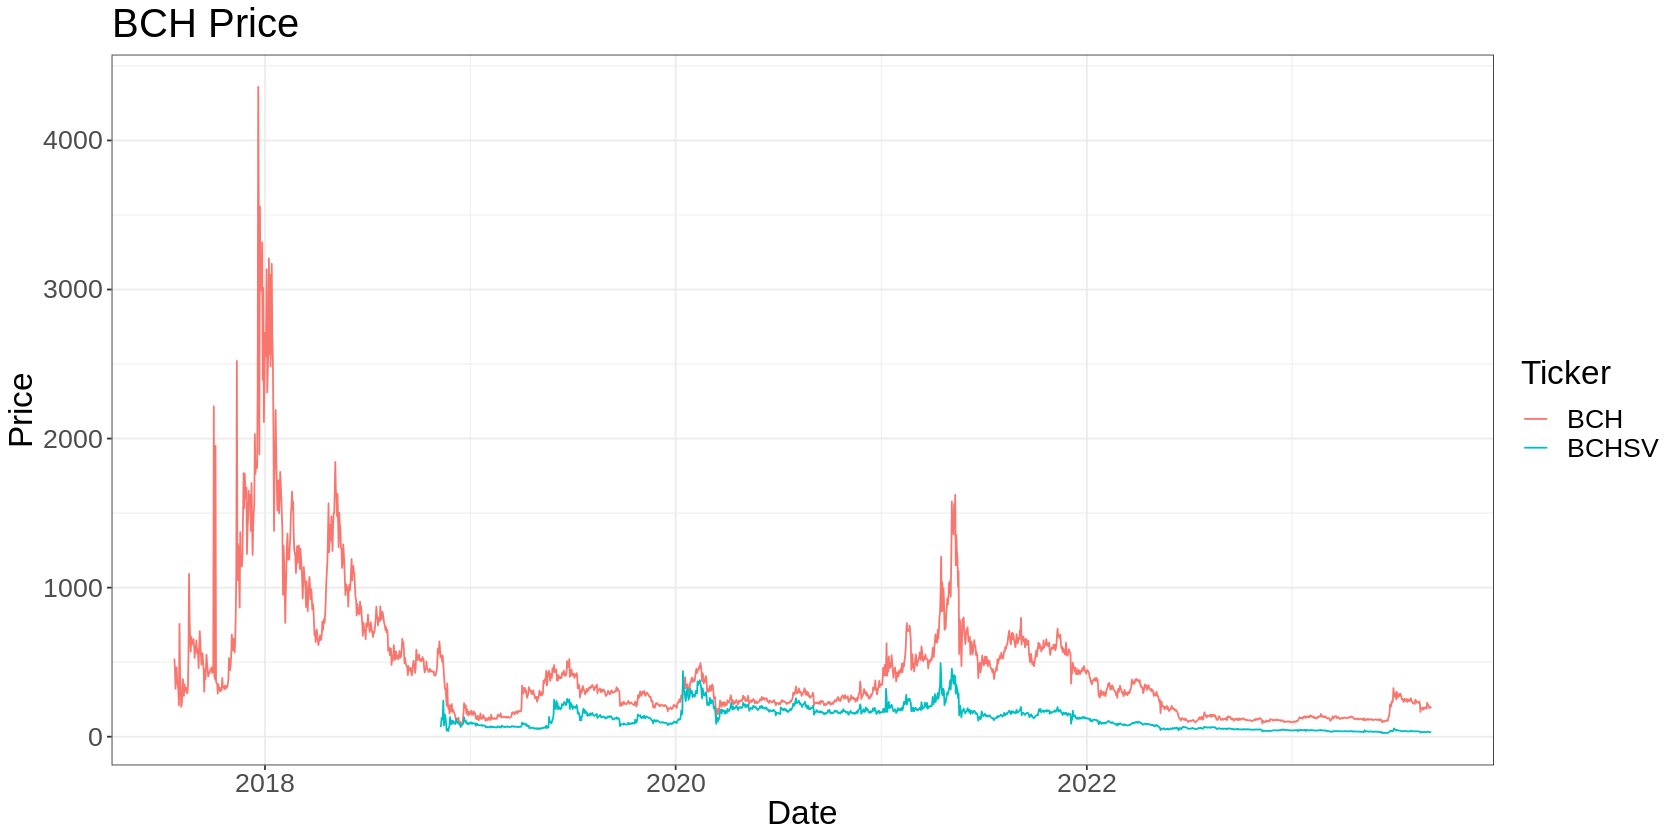

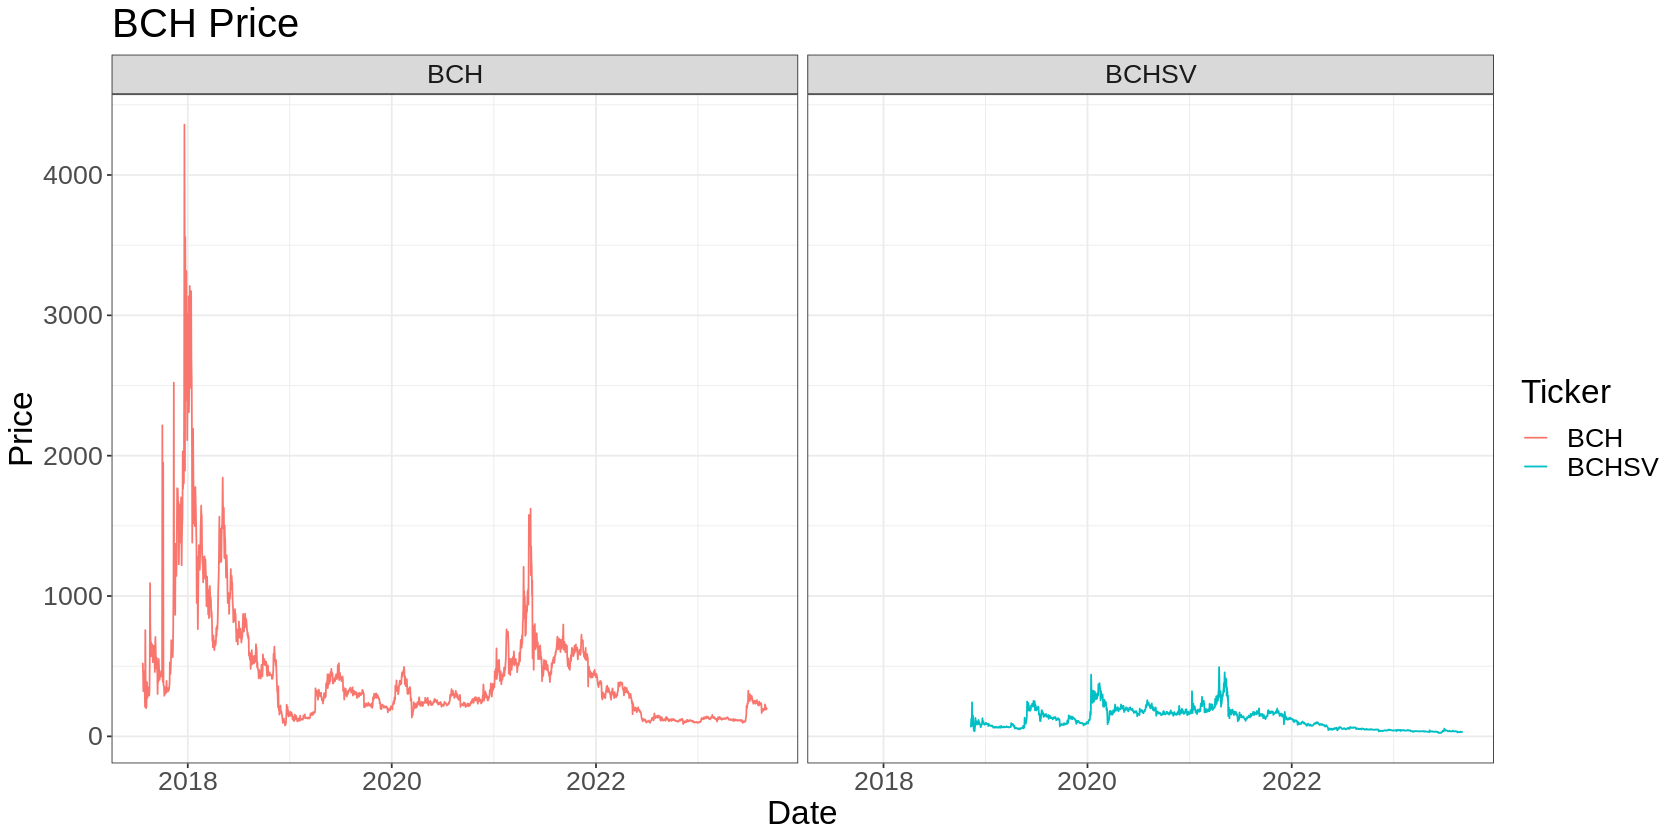

In [52]:
prices %>%
  filter(str_detect(Ticker, 'BCH')) %>%
  ggplot(aes(x=Date, y=Price, color = Ticker)) +
     geom_line() +
     ggtitle('BCH Price')

prices %>%
  filter(str_detect(Ticker, 'BCH')) %>%
  ggplot(aes(x=Date, y=Price, color = Ticker)) +
     geom_line() +
     facet_wrap(~Ticker) +
     ggtitle('BCH Price')

There's some bad data there in BCH - I can see at least four spikes that look dubious in the early history. Let's remove that data and interpolate prices as an approximation.

# A tibble: 5 × 5
  Ticker Date       Price      Volume MarketCapUSD
  <chr>  <date>     <dbl>       <dbl>        <dbl>
1 BCH    2017-08-02  321.  240022953.  5316488759.
2 BCH    2017-10-02  419.  165743029.  7054782881.
3 BCH    2017-10-05  376.  250365495.  5906668116.
4 BCH    2017-11-12 1091. 1539525410. 26587489806.
5 BCH    2018-11-21  219.  111415643.  4480555190.


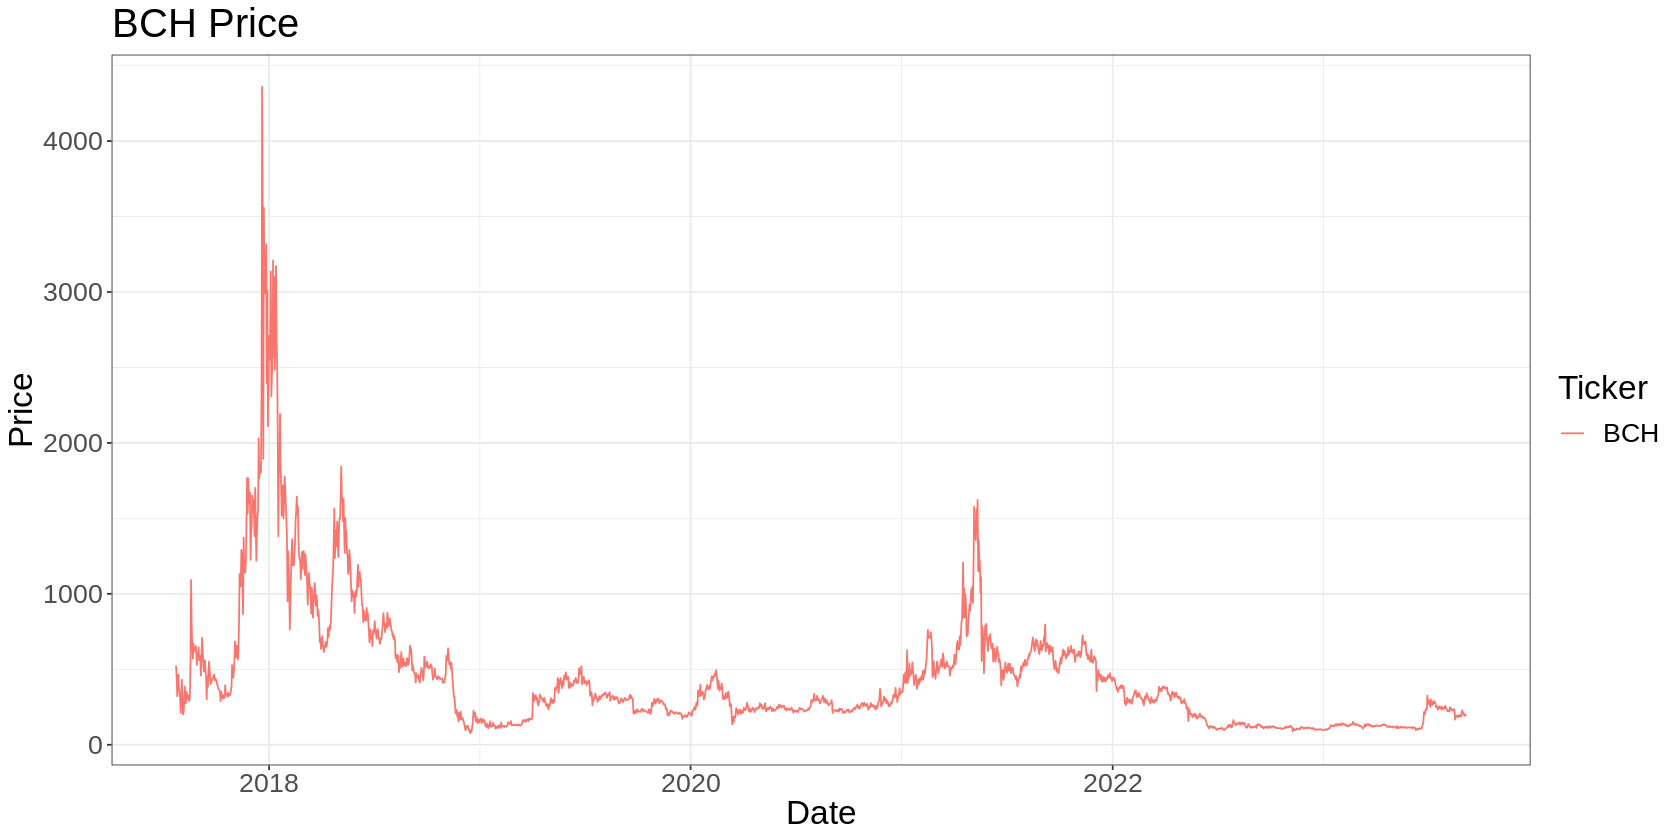

In [53]:
# 1. make a dataframe of updated rows
updated_rows <- prices %>%
  filter(Ticker == "BCH") %>%
  # find rows where the price today is more than twice the price from the day before and from the day after
  mutate(
    lag_price = dplyr::lag(Price),
    lead_price = dplyr::lead(Price)
  ) %>%
  filter(
    # 0.65 found by trial and error to isolate the rows we want to ditch
    lag_price < 0.65*Price,
    lead_price < 0.65*Price
  ) %>%
  # set today's price to half way between yesterday's and tomorrow's price
  mutate(Price = lag_price + (lead_price - lag_price)/2) %>%
  # select only the columns that were in our original prices dataframe
  select(Ticker, Date, Price, Volume, MarketCapUSD)

print(updated_rows)

# 2. remove the bad rows from our original prices dataframe
prices <- prices %>%
  filter(!(Ticker == "BCH" & Date %in% (updated_rows %>% pull(Date))))

# 3. merge our prices dataframe with our updated rows and sort
prices <- prices %>%
  bind_rows(updated_rows) %>%
  arrange(Date, Ticker)

# plot BCH to check
prices %>%
  filter(Ticker == 'BCH') %>%
  ggplot(aes(x = Date, y = Price, color = Ticker)) +
  geom_line() +
  ggtitle('BCH Price')

Not perfect but better and probably OK for this analysis. There's probably more bad data in here - we'll look at this later.

Let's plot market cap

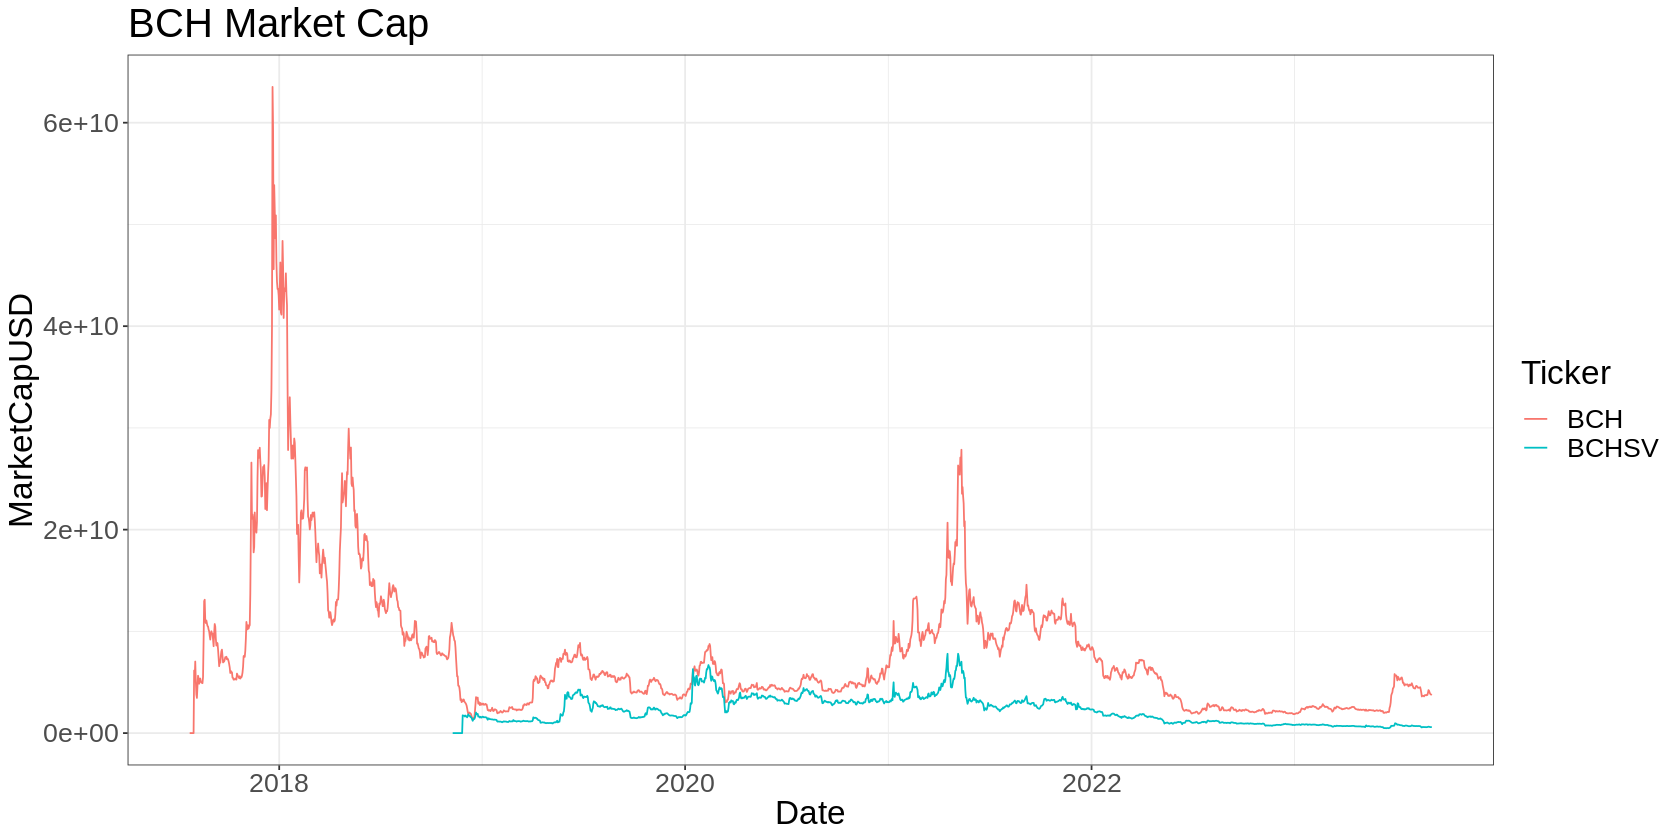

In [54]:
prices %>%
  filter(Ticker %in% c('BCH','BCHSV')) %>%
  ggplot(aes(x=Date, y=MarketCapUSD, color = Ticker)) +
    geom_line() +
    ggtitle('BCH Market Cap')

I think we should keep them both in our data set. Even though we know now that BCHSV lost the hard fork battle, we wouldn't have known that at the time we would have traeded.  

## BTC

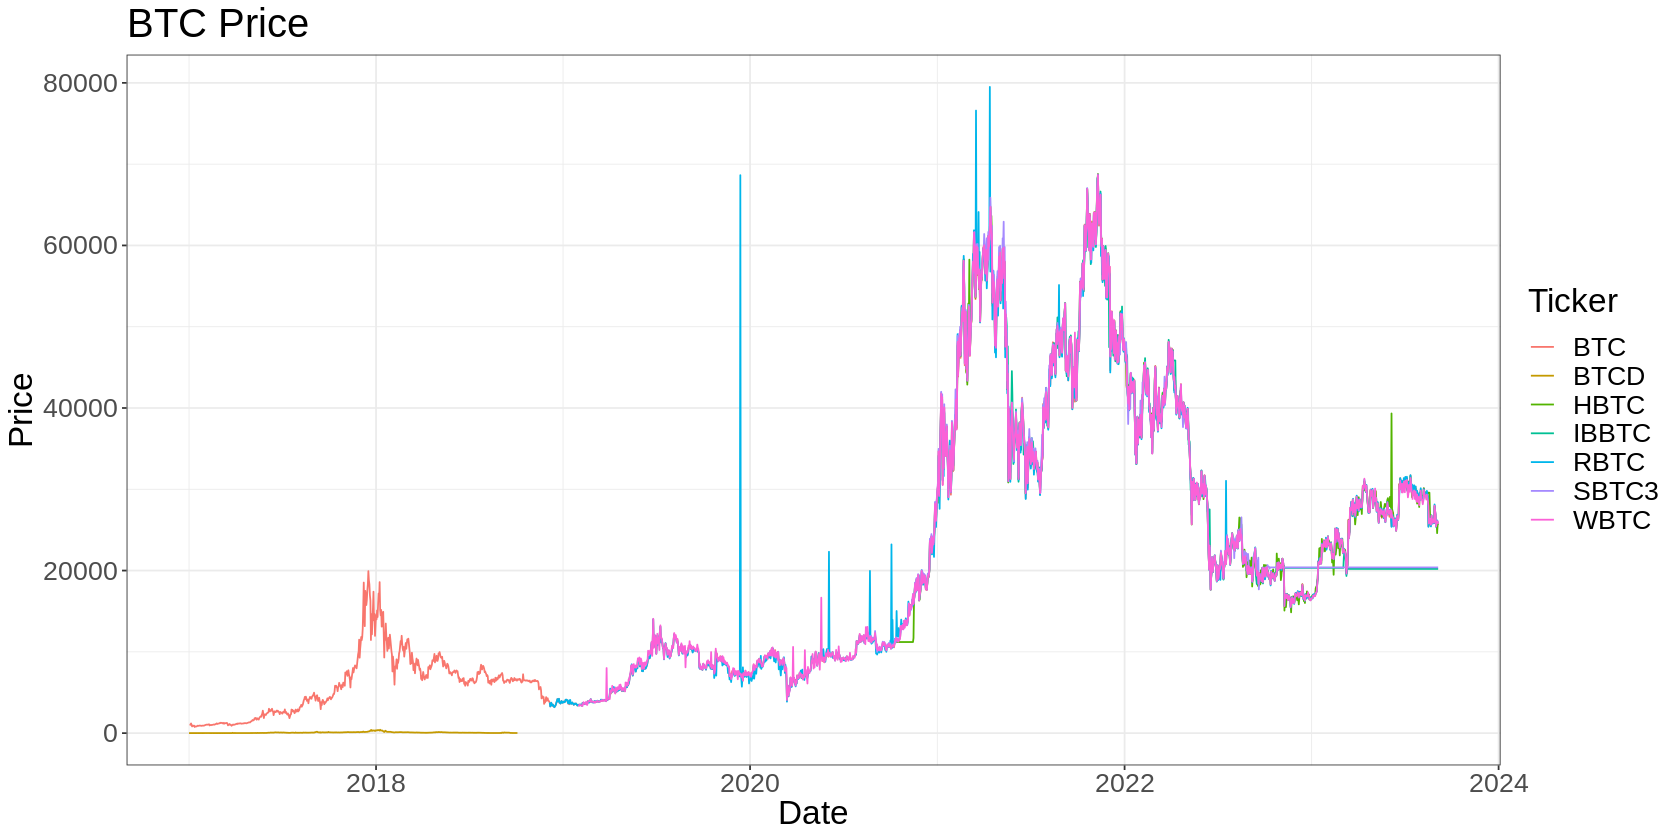

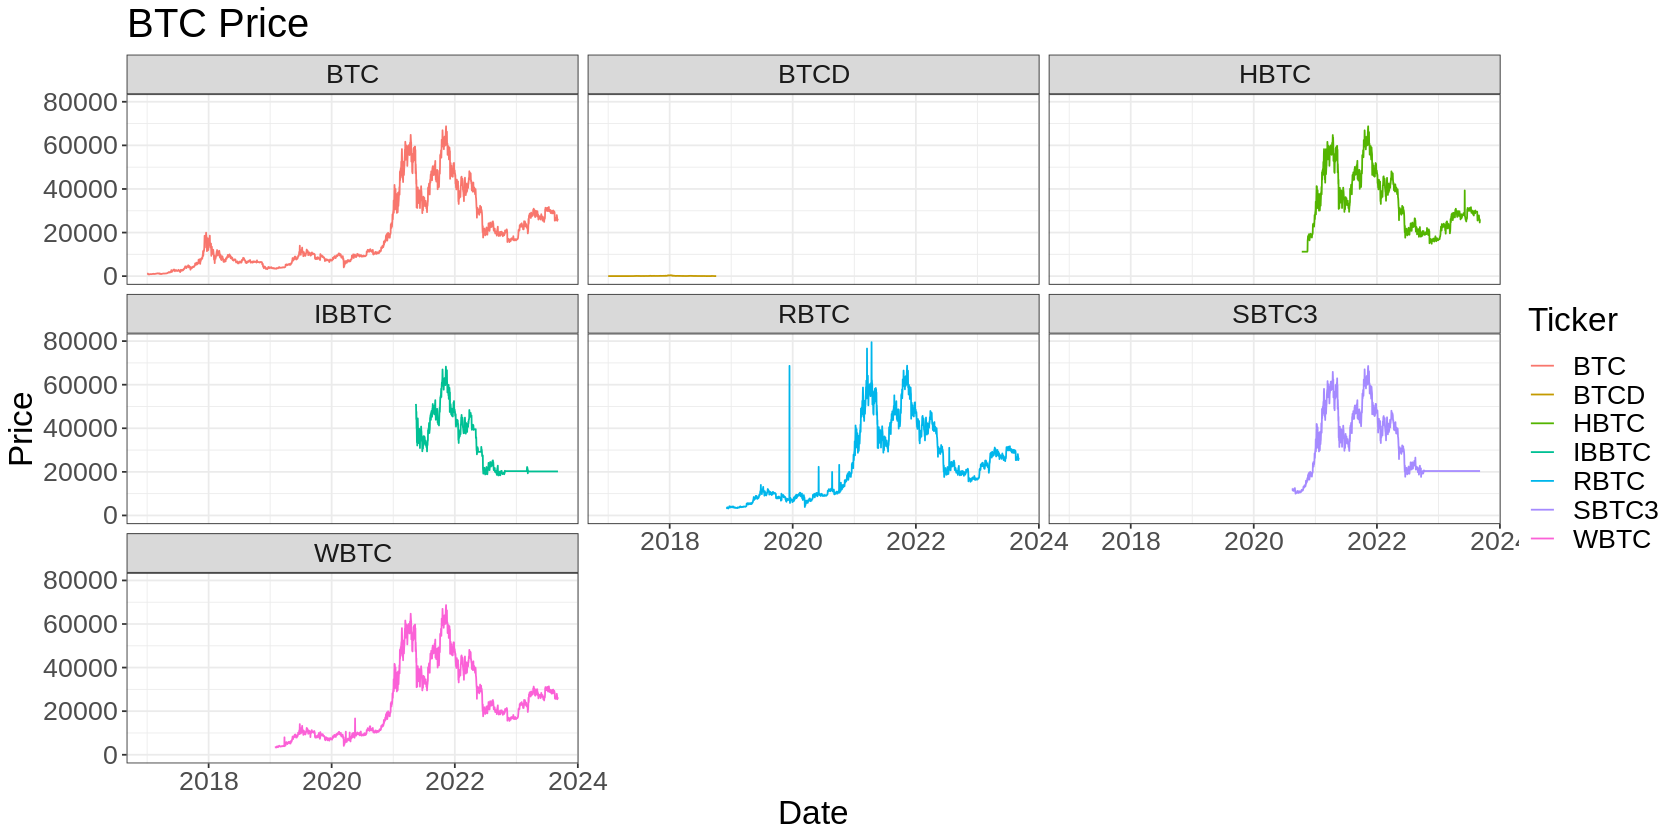

In [55]:
prices %>%
  filter(str_detect(Ticker, 'BTC')) %>%
  ggplot(aes(x=Date, y=Price, color = Ticker)) +
     geom_line() +
     ggtitle('BTC Price')

prices %>%
  filter(str_detect(Ticker, 'BTC')) %>%
  ggplot(aes(x=Date, y=Price, color = Ticker)) +
     geom_line() +
     facet_wrap(~Ticker) +
     ggtitle('BTC Price')

I'm going to ditch all of these... they appear to be the same thing. Note some bad data in there too.

In [56]:
prices <- prices %>%
  filter(!Ticker %in% c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3'))

Other problem children in our dataset may be "wrapped" coins... they usually begin with "W"

In [57]:
prices %>%
  filter(stringr::str_starts(Ticker, 'W')) %>%
  group_by(Ticker) %>%
  summarise(observations = n(),
            start_date = min(Date),
            end_date = max(Date)) %>%
  arrange(desc(Ticker)) %>%
  head(20)

Ticker,observations,start_date,end_date
<chr>,<int>,<date>,<date>
WXT,1527,2019-07-01,2023-09-05
WRX,1308,2020-02-05,2023-09-05
WOO,1020,2020-11-19,2023-09-05
WNXM,1132,2020-07-30,2023-09-05
WMT,623,2021-12-22,2023-09-05
WLD2,44,2023-07-24,2023-09-05
WIN4,1496,2019-08-01,2023-09-05
WILD2,848,2021-05-11,2023-09-05
WEMIX,971,2021-01-08,2023-09-05


Remove the wrapped tokens: WNXM and WBTC

In [58]:
prices <- prices %>%
  filter(!Ticker %in% c('WNXM', 'WBTC'))

Let's put this filtering in a single statement, to reuse in other notebooks.

In [59]:
# snippet: rw crypto remove duplicates v0.2
# Remove duplicate protocol coins concodex from data set
prices <- prices %>%
  filter(!Ticker %in% c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC'))

# Creating a market cap index to analyze

To create a non-biased universe we want to select the top n assets by marketcap (from the day before.)

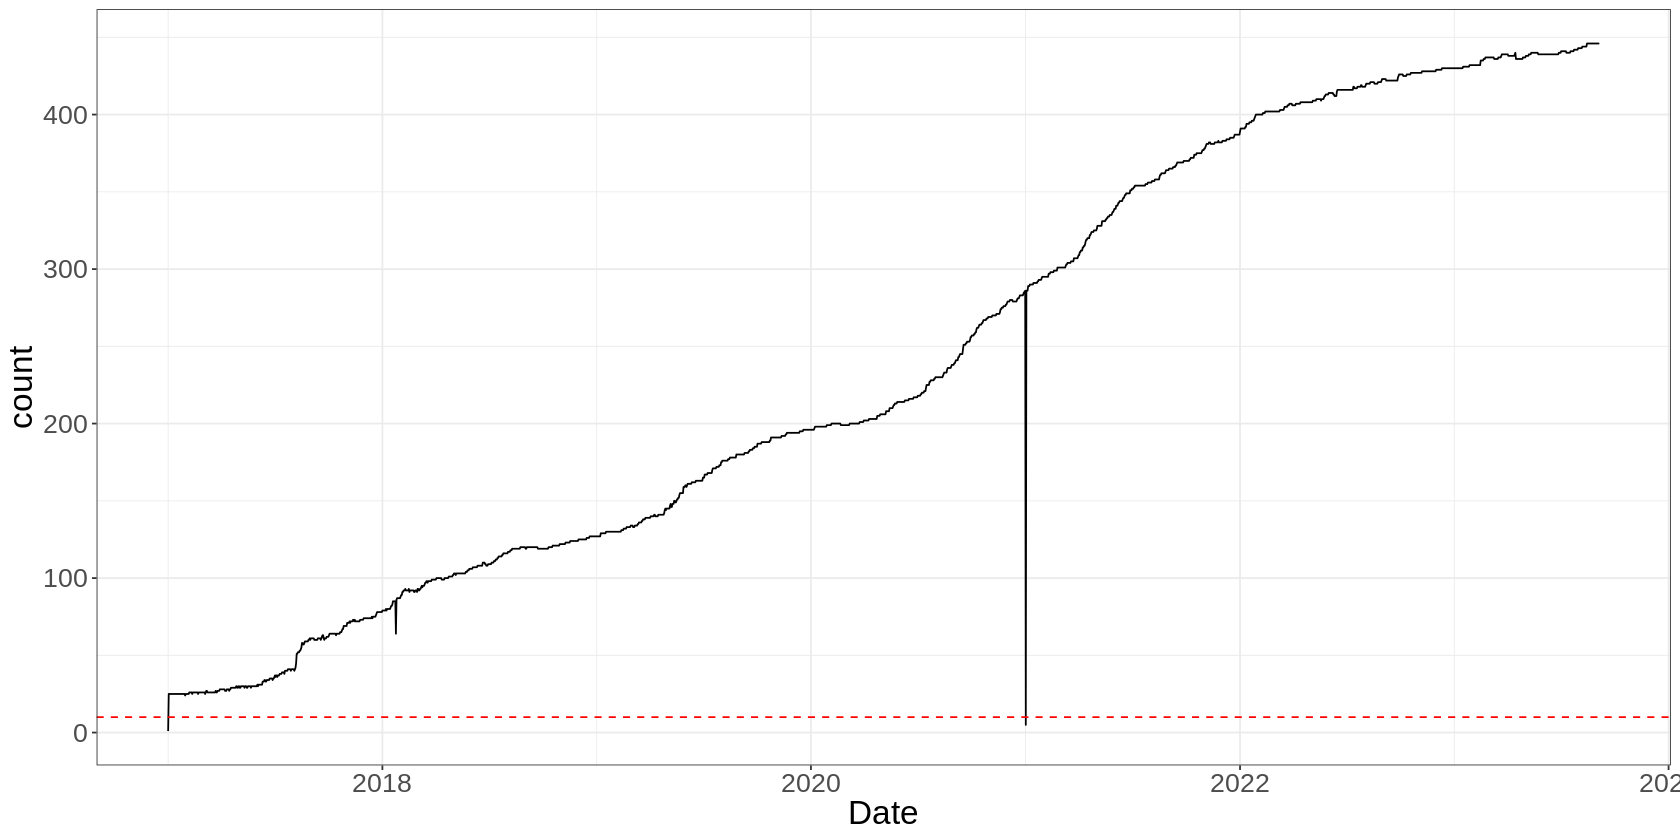

In [60]:
prices %>%
  group_by(Date) %>%
  summarise(count = n()) %>%
  ggplot(aes(x = Date, y = count)) +
    geom_line() +
    geom_hline(yintercept = 10, linetype = 'dashed', color = 'red')

What's going on on the days where we have those spikes? Feels like a data issue.

In [61]:
# which dates do those spikes occur on?
prices %>%
  group_by(Date) %>%
  summarise(count = n()) %>%
  mutate(lag_count = dplyr::lag(count)) %>%
  filter(count < 0.8*lag_count)

Date,count,lag_count
<date>,<int>,<int>
2018-01-24,64,85
2021-01-01,5,286


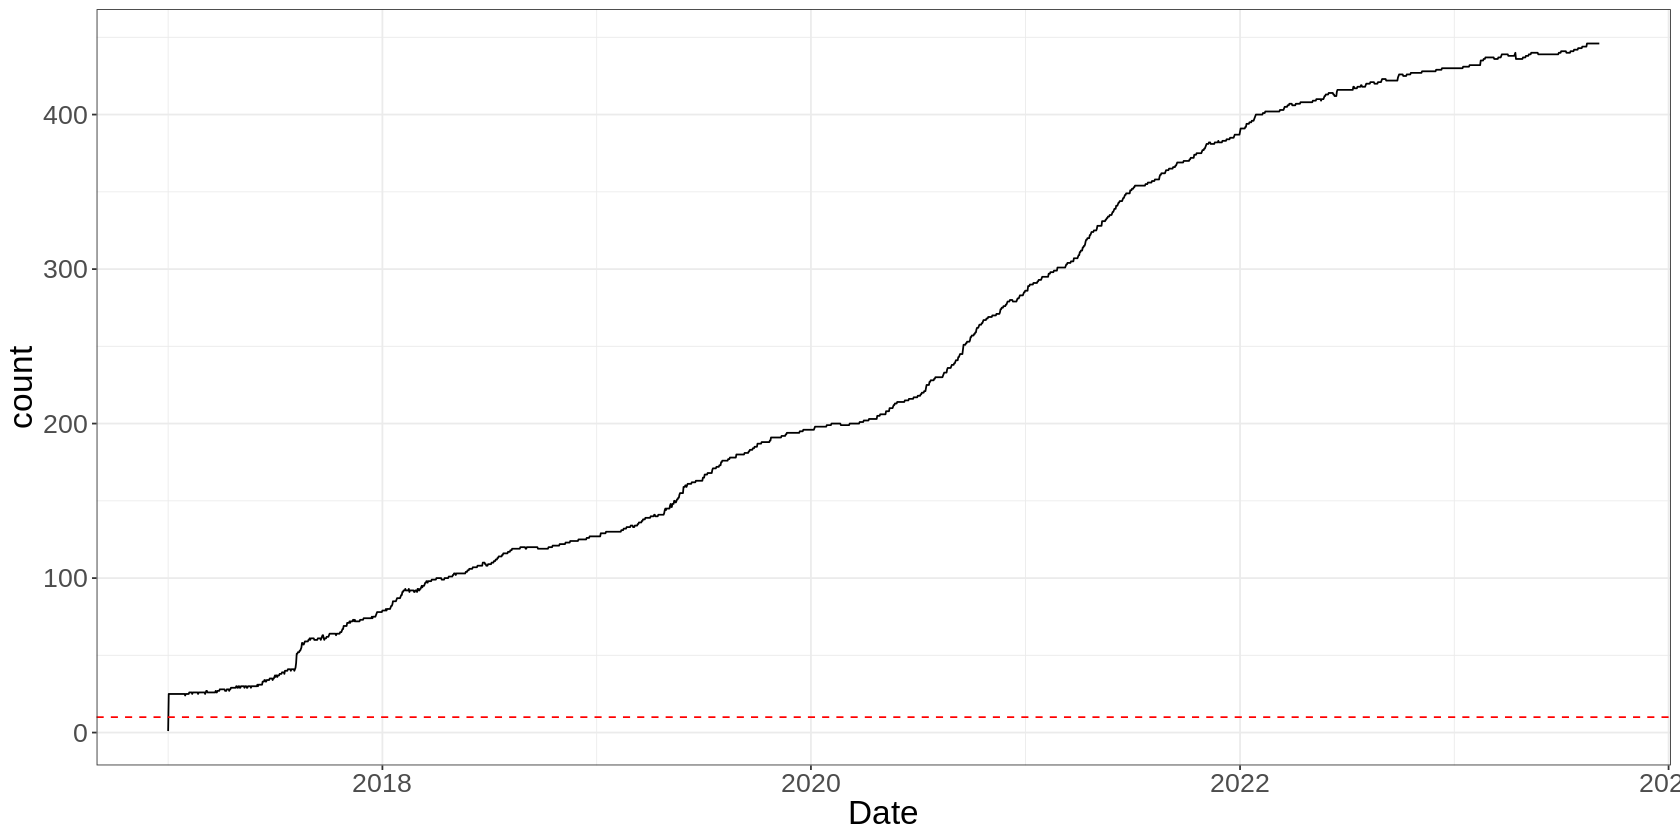

In [62]:
# remove observations on those dates, then fill forward from previous date

# 1. Get weird dates
weird_dates <- prices %>%
  group_by(Date) %>%
  summarise(count = n()) %>%
  mutate(lag_count = dplyr::lag(count)) %>%
  filter(count < 0.8*lag_count) %>%
  pull(Date)

# 2. Create new dataframe from the dates prior to our weird dates, then label them as our weird dates
prices_new <- prices %>%
  filter(Date %in% as.Date(weird_dates - 1)) %>%
  mutate(Date = Date + 1)

# 3. Filter out these weird rows
prices <- prices %>%
  filter(!Date %in% as.Date(weird_dates))

# 4. Combine the two dataframes
prices <- prices %>%
  bind_rows(prices_new) %>%
  arrange(Date, Ticker)

# replot
prices %>%
  group_by(Date) %>%
  summarise(count = n()) %>%
  ggplot(aes(x = Date, y = count)) +
    geom_line() +
    geom_hline(yintercept = 10, linetype = 'dashed', color = 'red')

First date for which we have 10 coins:

In [63]:
prices %>%
  group_by(Date) %>%
  summarise(count = n()) %>%
  filter(count >= 10) %>%
  summarise(min(Date))

min(Date)
<date>
2017-01-02


For a given ticker/date observation, set is_index to TRUE if:
 - the asset was in the top 10 coins by market cap the day before
 - the date is on or after 2017-01-03 (the day after our analysis universe starts)

In [64]:
universe <- prices %>%
  group_by(Date) %>%
  mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
  arrange(Date) %>%
  group_by(Ticker) %>%
  mutate(is_index = lag(cap_rank) <= 10 & Date >= '2017-01-03') %>%
  na.omit()

Let's look at the unique assets in our universe...

In [66]:
universe_assets <- universe %>%
  filter(is_index) %>%
  group_by(Ticker) %>%
  summarise(
    observations = n(),
    start_date = min(Date),
    end_date = max(Date)
  ) %>%
  arrange(Ticker)

universe_assets

Ticker,observations,start_date,end_date
<chr>,<int>,<date>,<date>
ADA,1790,2017-11-30,2023-09-05
AVAX,258,2021-09-19,2023-04-19
BCH,1480,2017-08-02,2023-07-08
BCHSV,641,2018-11-28,2021-01-04
BNB,1662,2019-02-07,2023-09-05
BTC,2437,2017-01-03,2023-09-05
BTG,24,2017-11-27,2017-12-23
CRO,90,2020-07-07,2021-11-25
DASH,412,2017-01-03,2020-01-17


We do have overlap between BCH and BCHSV - I'm not sure if we should be worried about that.

Let's look at the first consituents

In [67]:
universe %>%
  ungroup() %>%
  filter(is_index) %>%
  filter(Date == min(Date)) %>%
  arrange(cap_rank)


Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2017-01-03,1.029553e+03,196321881.9,16552062818,1,TRUE
ETH,2017-01-03,8.934787e+00,19180598.6,781653268,2,TRUE
XRP,2017-01-03,6.278160e-03,1140293.2,229377082,3,TRUE
LTC,2017-01-03,4.622272e+00,13239703.9,227565222,4,TRUE
XMR,2017-01-03,1.630787e+01,15975933.7,223204823,5,TRUE
ETC,2017-01-03,1.494416e+00,3871639.6,130754880,6,TRUE
DASH,2017-01-03,1.239979e+01,3965877.3,86744919,7,TRUE
STEEM,2017-01-03,1.588820e-01,187582.6,36860273,8,TRUE
XEM,2017-01-03,3.476726e-03,101281.9,31289790,9,TRUE


And the latest ones...

In [68]:
universe %>%
  ungroup() %>%
  filter(is_index) %>%
  filter(Date == max(Date)) %>%
  arrange(cap_rank)

Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2023-09-05,2.573866e+04,30720033818,501309507864,1,TRUE
ETH,2023-09-05,1.633007e+03,7085166694,196316359076,2,TRUE
BNB,2023-09-05,2.148119e+02,602857385,33048782546,3,TRUE
XRP,2023-09-05,5.048614e-01,1687042922,26746394842,4,TRUE
DOGE,2023-09-05,6.425824e-02,1442745059,8977522633,5,TRUE
ADA,2023-09-05,2.568713e-01,268176974,8687456087,6,TRUE
SOL,2023-09-05,2.055960e+01,1648727979,8080161988,7,TRUE
TRX,2023-09-05,7.834358e-02,3954195621,7168157966,8,TRUE
TONCOIN,2023-09-05,1.801576e+00,21585140,6182815895,9,TRUE


Plot the assets in our universe to look for bad data

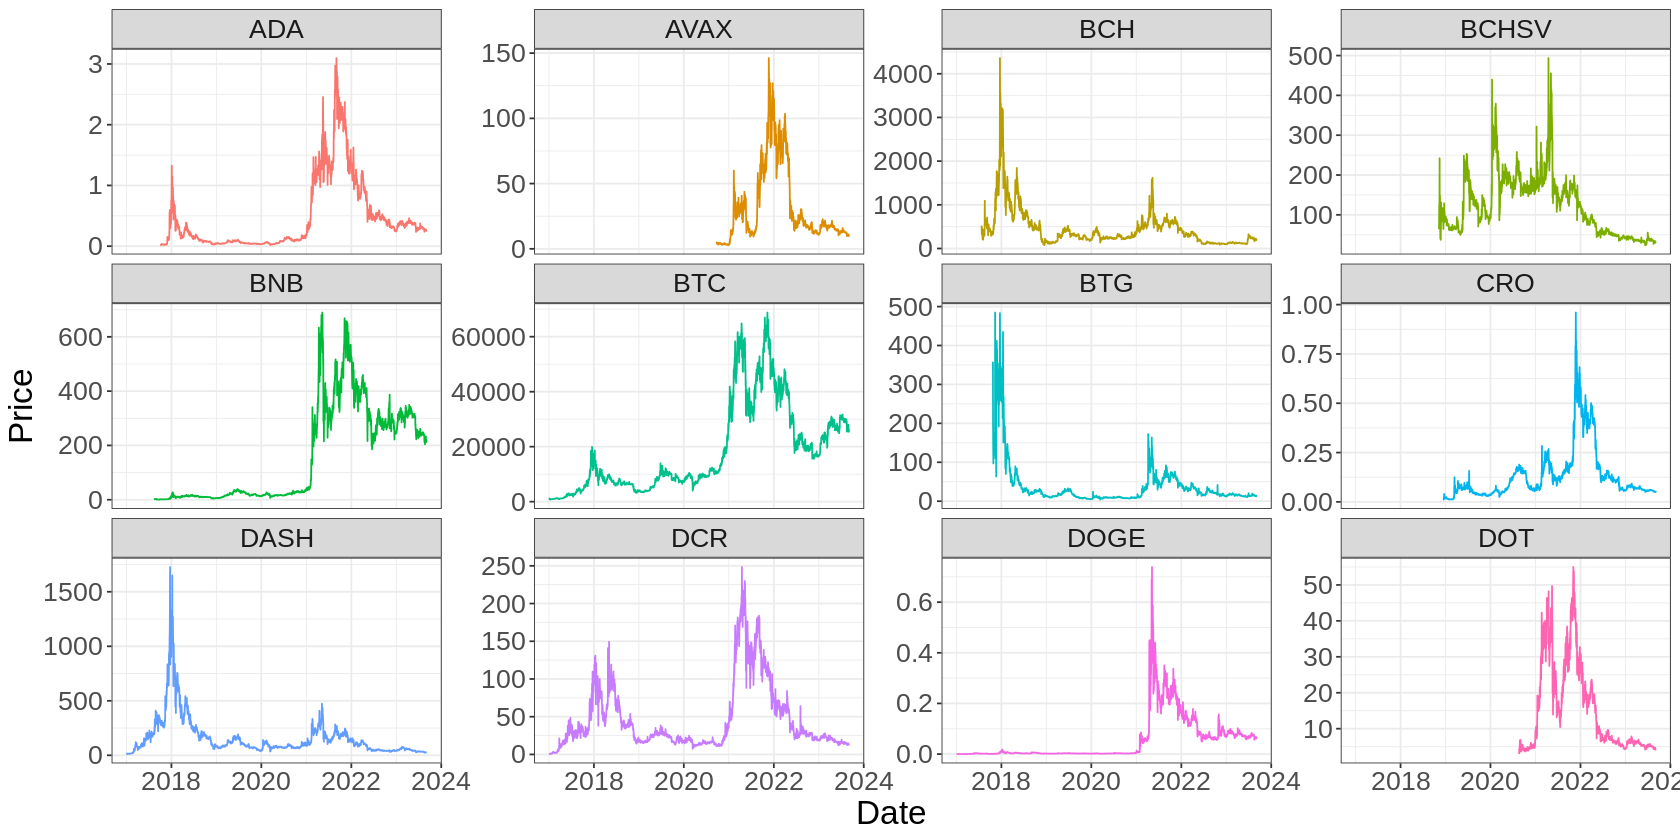

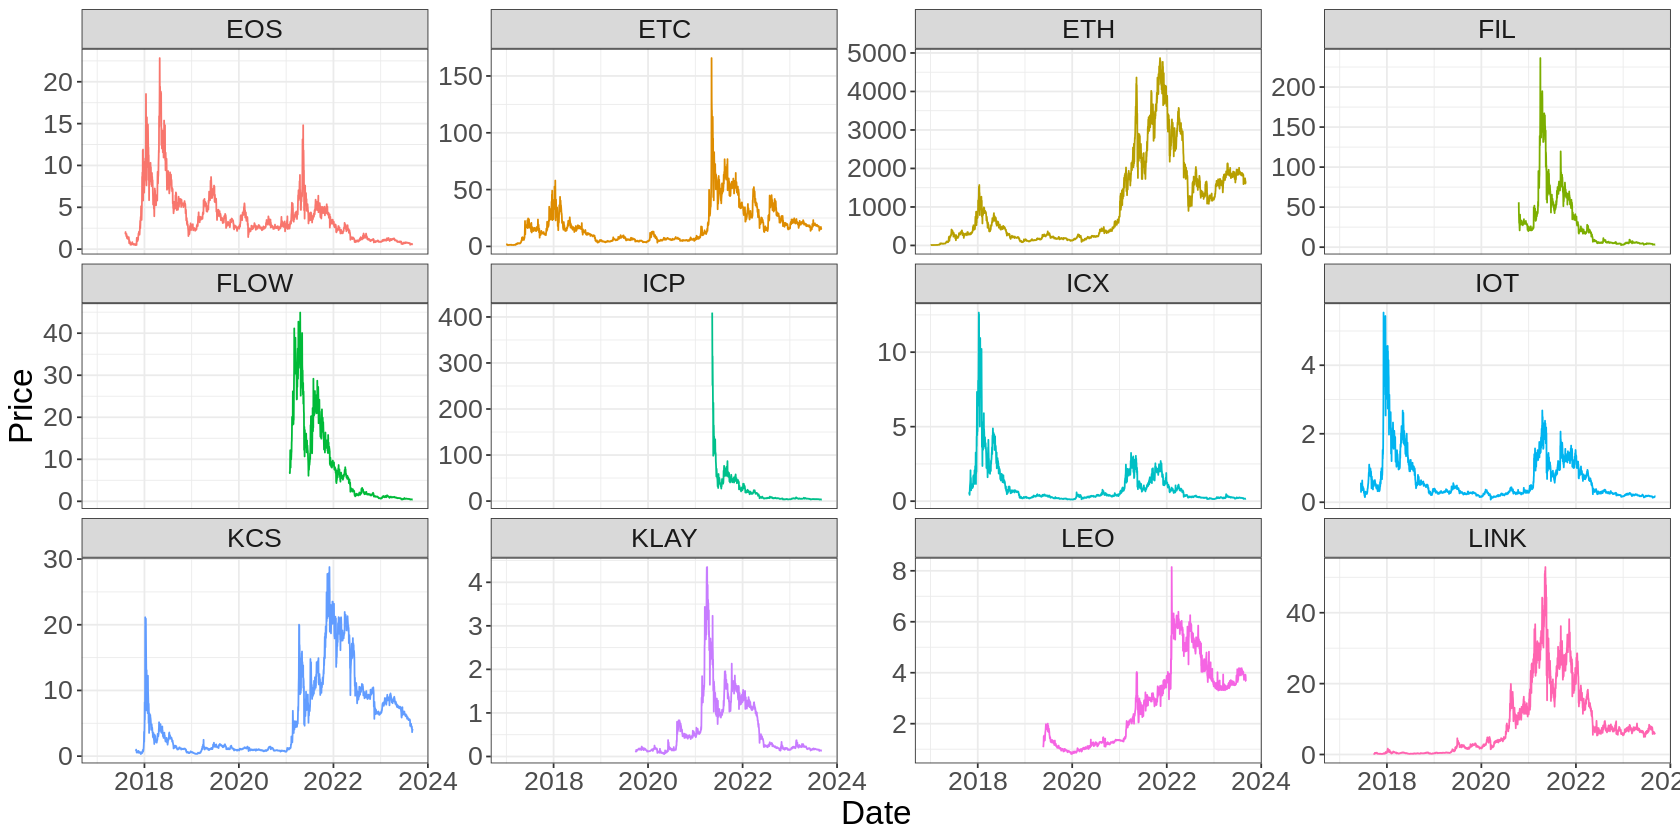

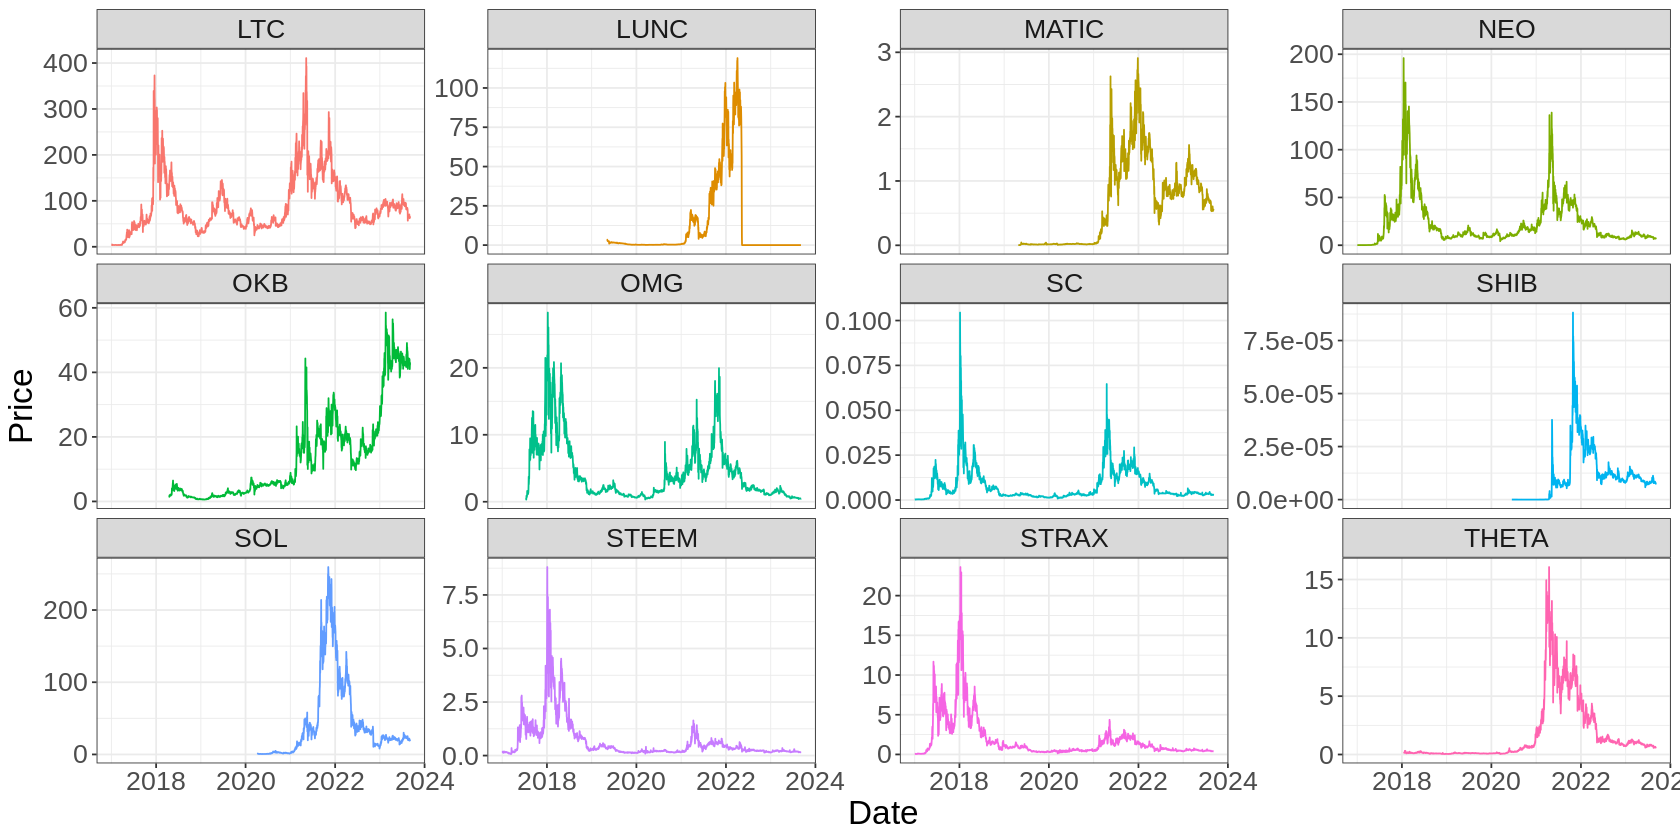

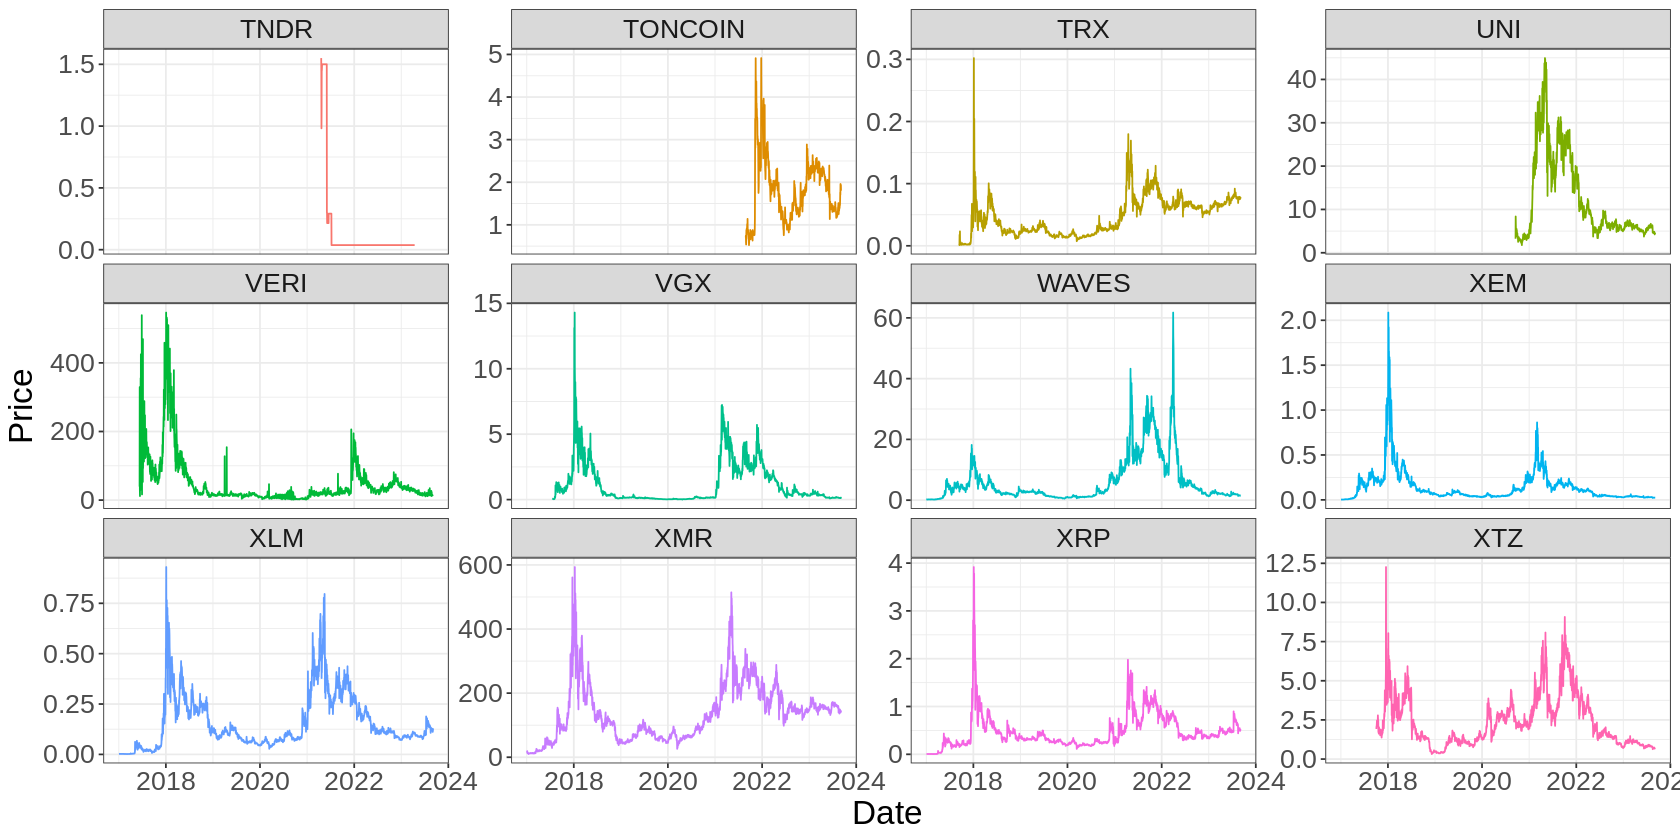

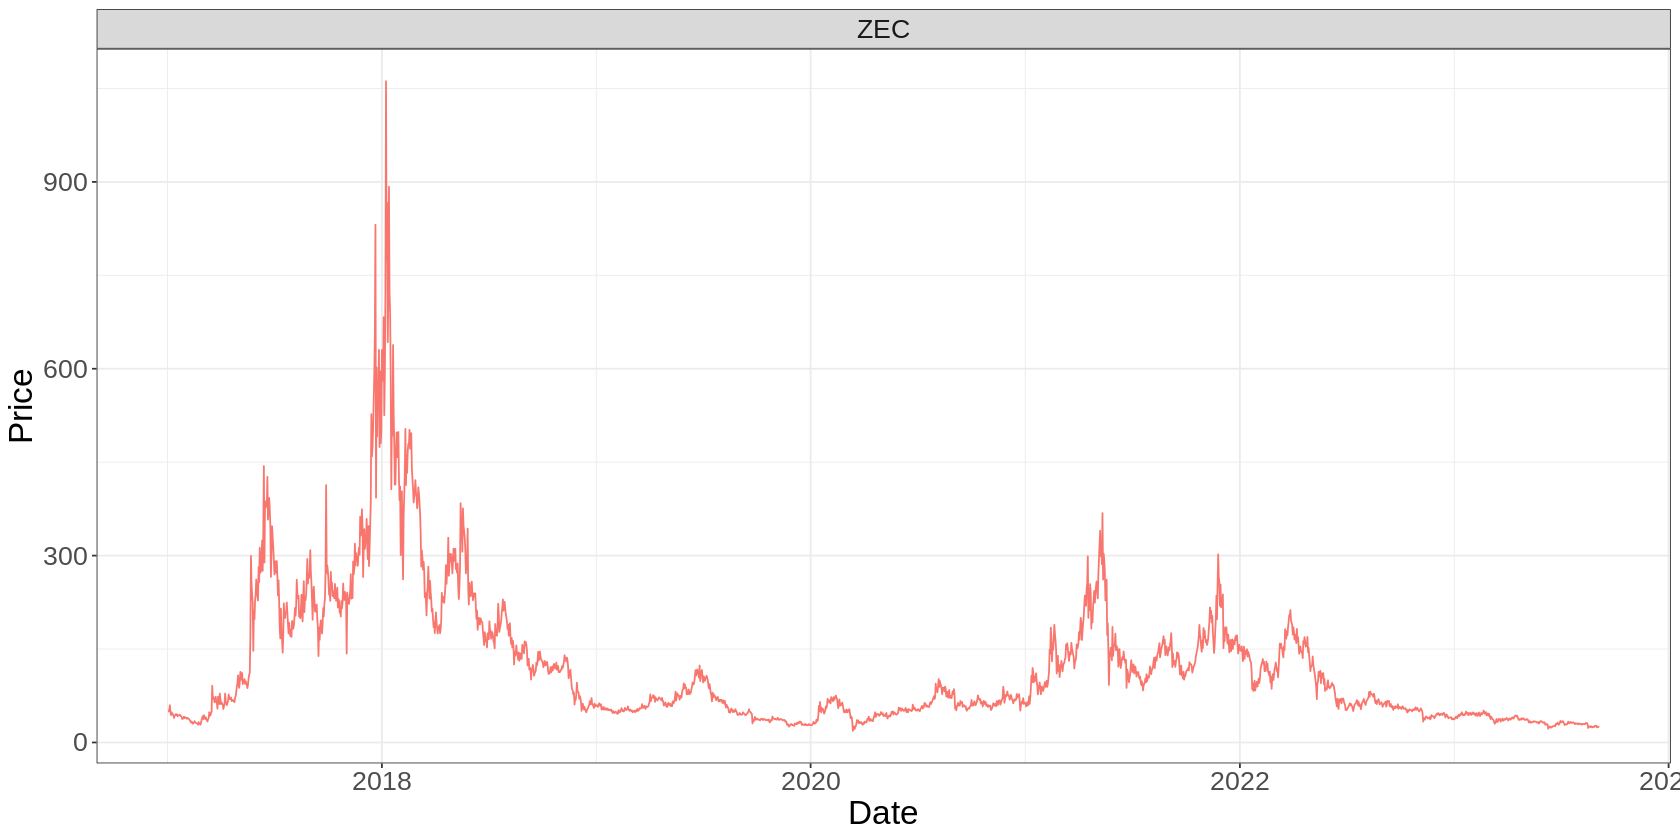

In [80]:
nrows <- 3
ncols <- 4
nplots <- length(universe_assets$Ticker)
i <- 1
nplotted <- 0
while (nplotted < nplots) {
  p <- prices %>%
    filter(Ticker %in% universe_assets$Ticker[i:(i + nrows*ncols - 1)]) %>%
    ggplot(aes(x = Date, y = Price, colour = Ticker)) +
    geom_line() +
    facet_wrap(~Ticker, scales = "free_y", nrow = nrows, ncol = ncols) +
    theme(legend.position = "none")

  print(p)

  i <- i + nrows*ncols
  nplotted <- nplotted + nrows*ncols
}

# prices %>%
#   filter(Ticker %in% universe_assets$Ticker[1:12]) %>%
#   ggplot(aes(x = Date, y = Price, colour = Ticker)) +
#   geom_line() +
#   facet_wrap(~Ticker, scales = "free_y") +
#   theme(legend.position = "none")

Looks OK for the most part... I can see some potentially bad prints in DCR. But it's only in our universe for a short period of time, outside of those bad prints.

# Function to Flag Universe Consituents

In [81]:
# snippet: rw crypto flag universe consituents v0.2
create_universe <- function(prices, n=10, min_constituents=10, stables, duplicates) {
  # Remove stablecoins and duplicates
  prices <- prices %>%
    filter(!Ticker %in% c(stables, duplicates))

  # Fix bad BCH data
  # 1. make a dataframe of updated rows
  updated_rows <- prices %>%
    filter(Ticker == "BCH") %>%
    # find rows where the price today is more than twice the price from the day before and from the day after
    mutate(
      lag_price = dplyr::lag(Price),
      lead_price = dplyr::lead(Price)
    ) %>%
    filter(
      # 0.65 found by trial and error to isolate the rows we want to ditch
      lag_price < 0.65*Price,
      lead_price < 0.65*Price
    ) %>%
    # set today's price to half way between yesterday's and tomorrow's price
    mutate(Price = lag_price + (lead_price - lag_price)/2) %>%
    # select only the columns that were in our original prices dataframe
    select(Ticker, Date, Price, Volume, MarketCapUSD)

  # 2. remove the bad rows from our original prices dataframe
  prices <- prices %>%
    filter(!(Ticker == "BCH" & Date %in% (updated_rows %>% pull(Date))))

  # 3. merge our prices dataframe with our updated rows and sort
  prices <- prices %>%
    bind_rows(updated_rows) %>%
    arrange(Date, Ticker)

  # Fix dates where something went wrong with the data
  # 1. Get weird dates
  weird_dates <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    mutate(lag_count = dplyr::lag(count)) %>%
    filter(count < 0.8*lag_count) %>%
    pull(Date)

  # 2. Create new dataframe from the dates prior to our weird dates, then label them as our weird dates
  prices_new <- prices %>%
    filter(Date %in% as.Date(weird_dates - 1)) %>%
    mutate(Date = Date + 1)

  # 3. Filter out these weird rows
  prices <- prices %>%
    filter(!Date %in% as.Date(weird_dates))

  # 4. Combine the two dataframes
  prices <- prices %>%
    bind_rows(prices_new) %>%
    arrange(Date, Ticker)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= 10 & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# call the function like this (don't do it now since we've already done all these steps)
# list of stablecoins from defi llama
# url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
# response <- httr::GET(url)

# stables <- response %>%
#   content(as = "text", encoding = "UTF-8") %>%
#   jsonlite::fromJSON(flatten = TRUE) %>%
#   pluck("peggedAssets") %>%
#   pull(symbol)

# duplicates <-  c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC')

# # create universe
# universe <- create_universe(prices, n=10, min_constituents=10, stables=stables, duplicates=duplicates)

# universe %>% head

Let's call it on fresh data and check we got the same result as before

In [82]:
freshprices <- rwRtools::crypto_get_coincodex()
universe_check <- prices <- create_universe(freshprices, n=10, min_constituents=10, stables=stables, duplicates=duplicates)

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


In [83]:
universe %>% print()
universe_check %>% print()

# A tibble: 583,896 × 7
# Groups:   Ticker [466]
   Ticker Date             Price      Volume MarketCapUSD cap_rank is_index
   <chr>  <date>           <dbl>       <dbl>        <dbl>    <int> <lgl>   
 1 TGC    2017-01-01    0.000336        18.1       14611.        1 FALSE   
 2 ATOM   2017-01-02    0.0121        5764.        90595.       23 FALSE   
 3 BTC    2017-01-02 1016.       187143686.  16343198030.        1 FALSE   
 4 DASH   2017-01-02   11.6        3853539.     81133797.        7 FALSE   
 5 DCR    2017-01-02    0.470         5507.      1638005.       20 FALSE   
 6 DGB    2017-01-02    0.000258     17273.      2012658.       19 FALSE   
 7 DOGE   2017-01-02    0.000226    171173.     24396684.       10 FALSE   
 8 ETC    2017-01-02    1.41       3450682.    122884998.        6 FALSE   
 9 ETH    2017-01-02    8.22      14252558.    719073653.        2 FALSE   
10 LSK    2017-01-02    0.158       226182.     15999897.       14 FALSE   
# ℹ 583,886 more rows
# A tibble: 583,8

In [84]:
diffs <- (universe == universe_check)
diffs[diffs == FALSE]

logical(0)

# Basic Analysis of Universe

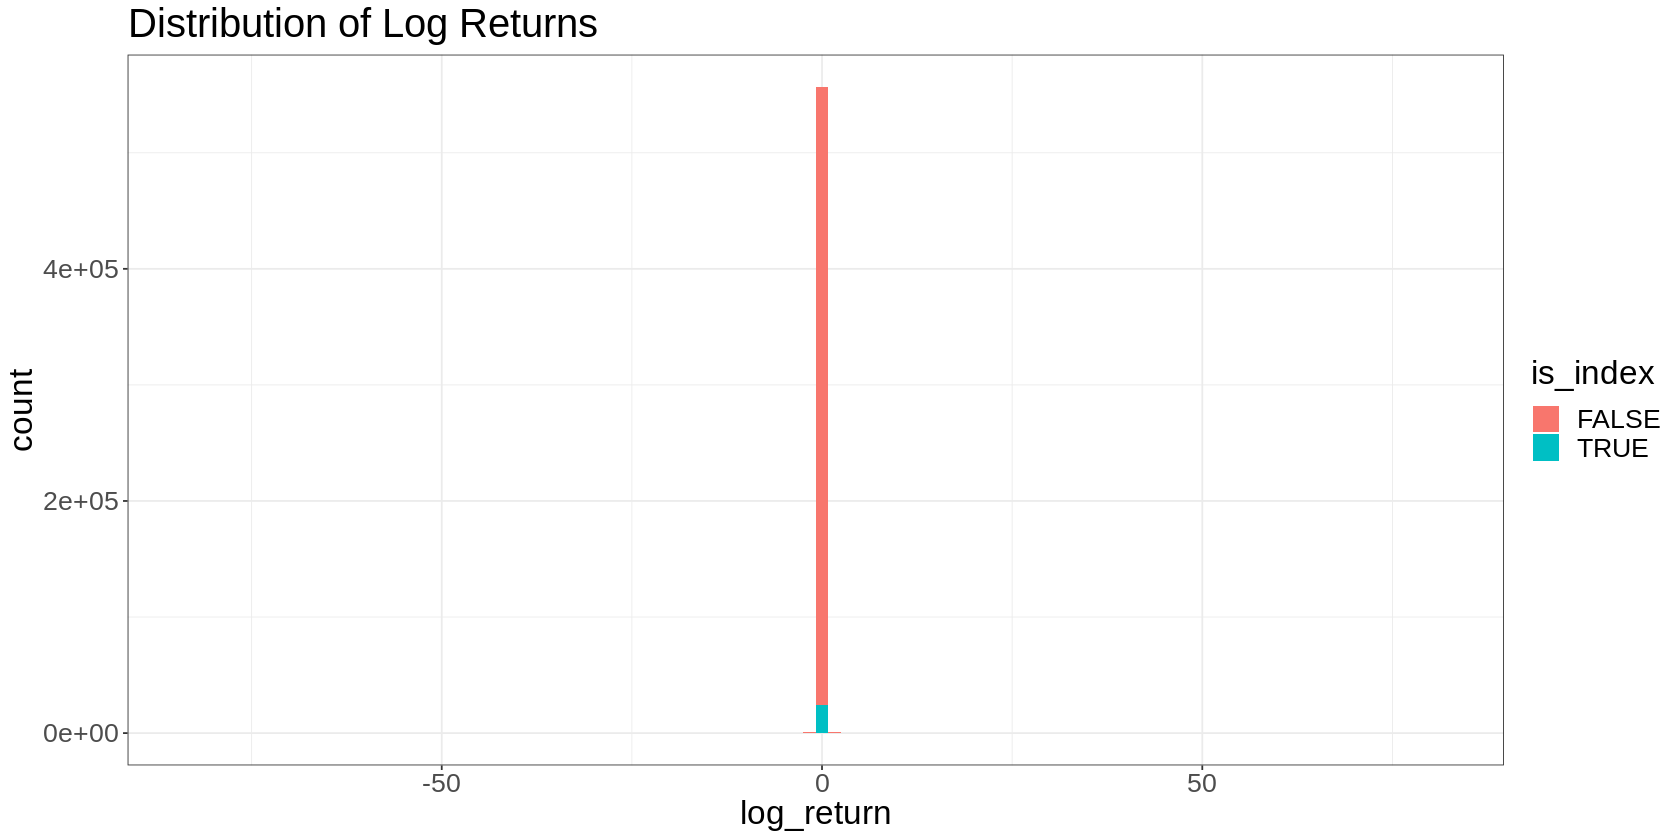

In [85]:
# snippet: rw crypto calc periodic returns v.0.1
# Calculate log and simple returns at the same periodicity as your data.
# Assumes there are no gaps in your data and your price column is price_usd (as it is in default coinmetrics data)
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  mutate(log_return = log(Price / lag(Price, n = 1))) %>%
  mutate(simple_return = Price / lag(Price, n = 1) - 1) %>%
  na.omit() %>%
  ungroup()

  # snippet: rw crypto plot return histogram v.0.1
returns %>%
  ggplot(aes(x = log_return, fill = is_index)) +
    geom_histogram(position = 'identity', bins = 100) +
    ggtitle('Distribution of Log Returns')

In [86]:
returns %>%
  group_by(is_index) %>%
  summarise(
    count = n(),
    min_return = min(log_return),
    max_return = max(log_return),
    mean = mean(log_return),
    median = median(log_return),
    sd = sd(log_return)
  )

is_index,count,min_return,max_return,mean,median,sd
<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,559062,-81.490706,81.378865,-0.0002265930,0.000000000,0.27659970
TRUE,24368,-1.652547,1.419384,0.0003199513,0.001615427,0.09931141


There are large tails and significant upward bias in our dataset.

The fact that the stuff in our index has a positive mean return while stuff outside has a negative mean return may suggest that the Coincodex universe itself may be introducing upward bias to our analysis.

We must be careful to make sure we bear this in mind in our analysis, and ensure that any factors are analyzed as long/short factors as well as long only to try to control for this potential bias as best we can.

## An Equal Weighted Index

Here we construct an index which is our index constituents equal weighted and rebalanced daily.

And compare that to a long only allocation to BTC.

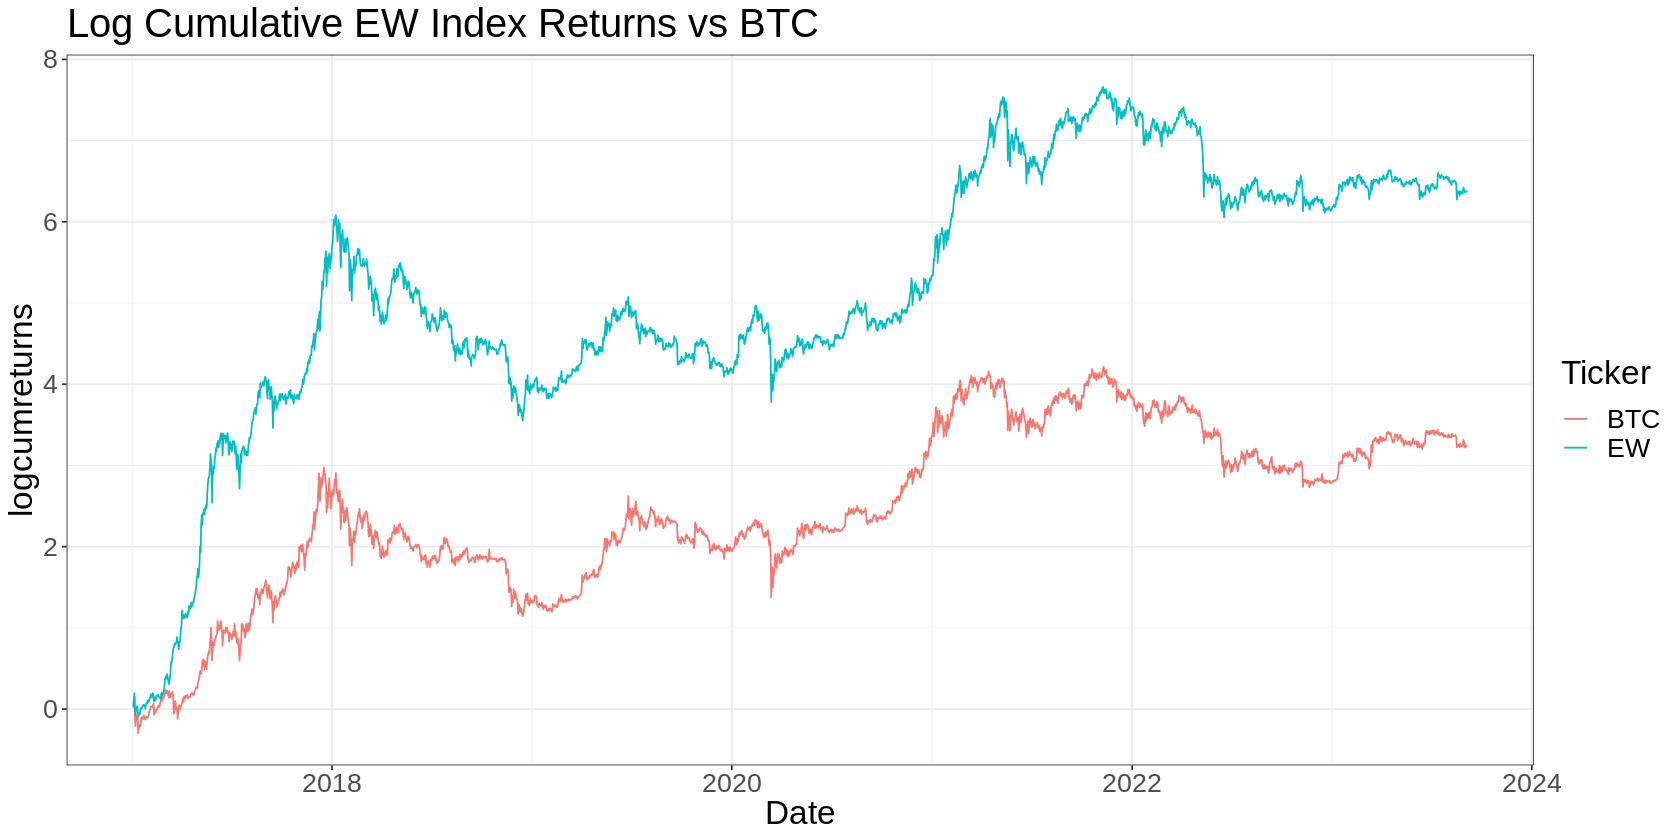

In [87]:
EWreturns <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  summarise(index_return = mean(simple_return)) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(
    logcumreturns = log(cumprod(1+index_return)),
    Ticker = 'EW'
  ) %>%
  select(Ticker, Date, logcumreturns)

start_date <- EWreturns %>%
  summarise(mindate = min(Date)) %>%
  pull(mindate)

BTCreturns <- returns %>%
  filter(Date >= start_date) %>%
  filter(Ticker == 'BTC') %>%
  mutate(logcumreturns = log(cumprod(1+simple_return))) %>%
  select(Ticker, Date, logcumreturns)

BTCreturns %>%
  bind_rows(EWreturns) %>%
  ggplot(aes(x=Date, y=logcumreturns, color=Ticker)) +
    geom_line() +
    ggtitle('Log Cumulative EW Index Returns vs BTC')